In [1]:
import sys
if (path := "C:/Users/Tom/PycharmProjects/python-hvac") not in sys.path:
    sys.path.append(path)

In [2]:
from hvac import Quantity, print_doc_string
from hvac.charts import LineChart
from hvac.sun import (
    Location, 
    ClimateType, 
    ReferenceDates
)
from hvac.cooling_load_calc import (
    WeatherData,
)

Q_ = Quantity

# 6. Cooling/Heating Load Calculation of a Building Thermal Zone
---

A thermal zone is a space or collection of spaces having similar space-conditioning requirements, the same heating and cooling setpoint, and is the basic thermal unit (or zone) used in modeling the building. In this notebook it is demonstrated how the cooling/heating load of a thermal zone can be estimated, after the model of the thermal zone has been programmed. 

## Geographical Location & Weather Data

First of all, we need to specify the geographical location of the building. This is done with an instance of the `Location` class.

In [3]:
print_doc_string(Location.__init__)

Creates a `Location` object with which the solar path and the solar
radiation can be determined at a given date and solar time.

Parameters
----------
fi:
    Latitude of the location; north positive; -pi/2 <= fi <= pi/2
L_loc:
    Longitude of the location; positive east of Greenwich, negative
    west of Greenwich.
date: Date, optional
    Current date at the location.
solar_time: Time, optional
    Current solar time at the location.
altitude: Quantity, optional
    Altitude of the location.
climate_type:
    Type of climate as defined in class `ClimateType`
timezone: optional, default UTC
    Tz-database identifier of the time zone of the location, indicating
    the offset from UTC (e.g. Etc/GMT-1).
    See: https://en.wikipedia.org/wiki/List_of_tz_database_time_zones
    The time zone is only used to determine the local standard time
    meridian. Do not specify a timezone with daylight saving time (DST),
    should it be in use at the location under consideration, as this may
  

In [4]:
location = Location(
    fi=Q_(51.183, 'deg'),
    L_loc=Q_(3.8, 'deg'),
    altitude=Q_(8, 'm'),
    climate_type=ClimateType.MID_LATITUDE_SUMMER,
    timezone='Etc/GMT-1'
)

We also need design data about the weather and solar radiation at the specified geographical location. For this the `WeatherData` class is used. This class provides two ways to  generate weather and solar radiation data: either through TMY data, or through climatic design data. As we are performing a cooling/heating load calculation here, it makes sense to use climatic design data, which are taken from ASHRAE's climatic design tables and are valid for the geographical location under consideration.

In [5]:
weather_data = WeatherData.create_from_climatic_design_data(
    location=location,
    date=ReferenceDates.get_date_for('Jun'),  # this returns the "design day" for June
    T_db_des=Q_(24.2, 'degC'),
    T_db_rng=Q_(11.8, 'K'),
    T_wb_mc=Q_(18.0, 'degC'),
    T_wb_rng=Q_(5.6, 'K')
)

It should be noted that when the `WeatherData` object is created, we have specified a particular day of the year (here we have used class `ReferenceDates` -defined in package `sun`- to get a specific reference day in the given month of the year). This particular day is referred to as the "design day".  

## Modeling the Thermal Zone

The code for modeling the thermal zone has been written outside this notebook, in a separate Python module, `thermal_zone_example.py`. To create the thermal zone object -an instance of class `ThermalZone`- in this notebook, we will import a function from the module to create this object here. The function call needs our `WeatherData` object and the setpoint for the air temperature in the thermal zone.  

In [6]:
from thermal_zone_example import create_zone

In [7]:
zone = create_zone(weather_data, T_int_des=Q_(20, 'degC'))

## Simulation of the Thermal Zone

A simulation of the thermal zone simulates **the temperature feedback control of the zone-air temperature** on an hourly basis (i.e. at each hour of the selected design day). Several heat gains from outside, and also from inside the zone may cause the zone-air temperature to fluctuate widely. Aim of the temperature control is to keep the actual zone-air temperature near its setpoint temperature. A temperature controller measures the deviation between the setpoint value and the actual value. Depending on the magnitude and sign of the deviation and the implemented control algorithm, the controller commands the HVAC-system to extract more or less heat from the zone air (air cooling), or to release more or less heat to the zone air (air heating). In the simulation it is assumed that heat is directly extracted from the zone air, or directly released into the zone air, i.e., the controller directly controls the thermal output power of the HVAC-system. From the simulation, the peak thermal power, as well in cooling, as in heating mode, and the daily cooling and/or heating need of the zone (i.e. the daily amount of thermal energy delivered by the HVAC-system to the zone for air cooling and/or air heating) can be estimated.

To run a simulation of the thermal zone, we call function `simulate(...)` on our `ThermalZone` object.

In [8]:
print_doc_string(zone.simulate)

Simulates the temperature feedback control of the zone-air 
temperature on the selected design day. 
        
Parameters
----------
setpoint:
    The setpoint for the zone-air temperature.
K_p:
    The proportional gain of the temperature controller.
K_i:
    The integral gain of the temperature controller.
num_cycles:
    The number of days the selected design day needs to be repeated 
    before the simulation ends. When the simulation starts, the initial 
    values of all system state variables are set to zero, and the daily,
    24h cycle of system input values needs to be repeated a number of 
    days until the system shows a harmonic periodic behavior in time and 
    the zone-air temperature 'T_za' has settled around the setpoint. 
    However, after the simulation has finished, only the last 24 hours 
    of the simulation will be returned.
units:
    Dictionary with the principal measuring units of the system 
    parameters. There are only three principal measuring units:
 

In [9]:
sim_result = zone.simulate(
    setpoint=Q_(22, 'degC'),
    K_p=Q_(0.5, 'kW / K'),
    K_i=Q_(1.67, 'W / (K * s)'),  # integration time = K_p / K_i = 5 min
    num_cycles=20,
    units={'time': 'hr'},
    reduced_order=8
)

> **Note**<br>
> As the thermal zone is a "slow system", it is always a good idea to set the timescale of a simulation to hours (instead of the default seconds). 

## Peak Loads and Daily Thermal Energy Needs

Through the returned dataobject `sim_result`, we have access to several results that were calculated in the simulation routine. One of the results we are most interested in is the peak heating and/or cooling rate on the selected design day, as we will need this to design and size the HVAC-system.

In [10]:
print(
    f"- peak cooling load on design day = {sim_result.Q_hvac_cool_pk.to('kW'):~P.3f}",
    f"- peak heating load on design day = {sim_result.Q_hvac_heat_pk.to('kW'):~P.3f}",
    f"- daily demand for cooling on design day = {sim_result.E_hvac_cool.to('kW * hr'):~P.1f}",
    f"- daily demand for heating on design day = {sim_result.E_hvac_heat.to('kW * hr'):~P.1f}",
    sep='\n'
)

- peak cooling load on design day = -3.390 kW
- peak heating load on design day = 0.000 kW
- daily demand for cooling on design day = 35.9 h·kW
- daily demand for heating on design day = 0.0 h·kW


We can plot the hourly values of the thermal load of the zone in a line chart. 

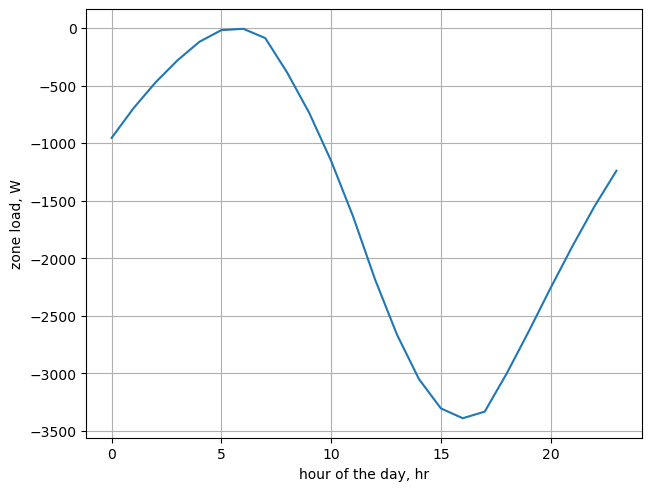

In [11]:
load_chart = LineChart()
load_chart.add_xy_data(
    label='zone load',
    x1_values=sim_result.time.to('hr').magnitude,
    y1_values=sim_result.Q_hvac.to('W').magnitude
)
load_chart.x1.add_title('hour of the day, hr')
load_chart.y1.add_title('zone load, W')
load_chart.show()

The zone load is compensated by the HVAC-system based on the measurement and the feedback of the zone-air temperature to the temperature controller of the zone. The course of the zone-air temperature can also be displayed in a line chart.

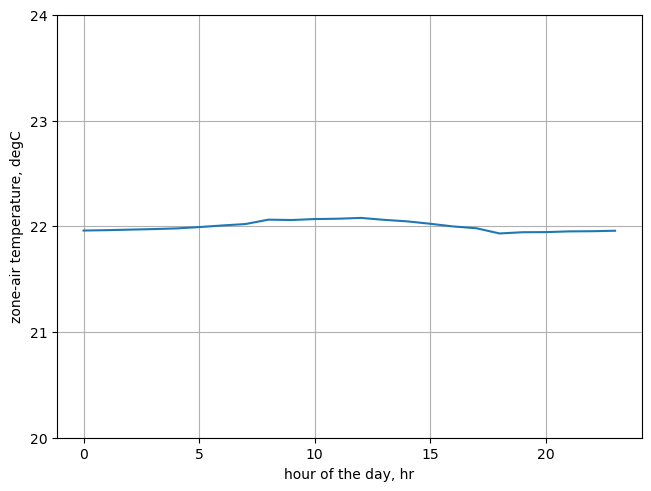

In [12]:
zone_air_temp_chart = LineChart()
zone_air_temp_chart.add_xy_data(
    label='zone-air temperature',
    x1_values=sim_result.time.to('hr').magnitude,
    y1_values=sim_result.T_za.to('degC').magnitude
)
zone_air_temp_chart.x1.add_title('hour of the day, hr')
zone_air_temp_chart.y1.add_title('zone-air temperature, degC')
zone_air_temp_chart.y1.scale(20, 25, 1)
zone_air_temp_chart.show()

## Heat Gains

The need for temperature control of the zone air is due to heat gains in the zone. Heat can enter the zone in several ways:
- by thermal conduction from outdoors (through exterior building elements, exterior doors, and windows) and from adjacent zones (through interior building elements and interior doors), 
- by solar radiation through windows,
- by internal heat gains present inside the zone (people, equipment, and lighting),
- by outdoor air infiltration through the building envelope and by ventilation (supply of ventilation air to the zone or by air transfer from adjacent zones).

Not all the heat is directly transferred to the zone air. A distinction is made between a convective fraction and a radiative fraction. The convective fraction of heat gains is directly transferred to the zone air through convection. The radiative fraction of heat gains is considered to be first absorbed by the interior mass of the zone (mainly the floor, but also furniture, partition walls, etc. add to the internal mass of a zone) and is later on transferred by convection to the zone air driven by the temperature difference between the interior mass and zone air.

Also, in cooling, moisture added to the zone air may present itself as a thermal load to the HVAC-system. When humid air is cooled in an air-cooling coil, moisture condenses on the surface of the coil. When water vapor condenses, it releases so-called latent heat (heat of condensation/vaporization) which is also captured by the cooling water or refrigerant on the other side of the heat exchanger. Moisture can be added to the zone air by internal heat gain sources in the zone, like people, or through air infiltration or (mechanical) ventilation.

To get an overview of the calculated, hourly values of the main heat gains in the zone (conduction heat gain, solar heat gain, internal heat gain, and ventilation heat gain), we can call the method `heat_gains_overview(...)` on our `ThermalZone` object, specifying the measuring unit in which we want to see the heat gain values (the default measuring unit is Watts, 'W'). This method will return the hourly values of the heat gains in a Pandas `DataFrame` object.

In [13]:
heat_gain_overview = zone.heat_gains_overview()
heat_gain_overview

heat gain       Q_cond              Q_sol               Q_ihg                \
type              conv          rad  conv          rad   conv    rad    lat   
0           575.095710  -435.711551   0.0     0.000000    0.0    0.0    0.0   
1           423.170952  -414.448005   0.0     0.000000    0.0    0.0    0.0   
2           290.066163  -394.468750   0.0     0.000000    0.0    0.0    0.0   
3           172.174807  -384.481554   0.0    38.003668    0.0    0.0    0.0   
4            56.003453  -421.134858   0.0   221.265898    0.0    0.0    0.0   
5           -42.200538  -508.679287   0.0   620.642012    0.0    0.0    0.0   
6           -93.787480  -611.375937   0.0   991.944611    0.0    0.0    0.0   
7           -82.871548  -690.151577   0.0  1351.081024    0.0    0.0    0.0   
8           -15.768165  -792.049627   0.0  1884.585746   94.5  130.5  165.0   
9           146.483590  -887.249051   0.0  2612.079325   94.5  130.5  165.0   
10          354.557465  -992.084491   0.0  3446.305886   94.5  130.5  165.0   
11          621.962846 -1063.127923   0.0  3936.462648   94.5  130.5  165.0   
12          904.239487 -1118.507505   0.0  4077.795887  157.5  217.5  275.0   
13         1205.427475 -1126.880093   0.0  3888.694072  157.5  217.5  275.0   
14         1464.534773 -1095.034873   0.0  3596.339347  157.5  217.5  275.0   
15         1667.142594 -1007.864727   0.0  2990.072578  157.5  217.5  275.0   
16         1774.333070  -903.096394   0.0  2334.274068  157.5  217.5  275.0   
17         1779.285177  -823.555292   0.0  1732.989592  157.5  217.5  275.0   
18         1729.197833  -697.199550   0.0  1010.044261    0.0    0.0    0.0   
19         1553.503958  -592.552341   0.0   402.851649    0.0    0.0    0.0   
20         1346.935642  -524.950657   0.0    28.879002    0.0    0.0    0.0   
21         1131.196815  -497.834648   0.0     0.000000    0.0    0.0    0.0   
22          926.835776  -479.327892   0.0     0.000000    0.0    0.0    0.0   
23          742.901333  -457.946180   0.0     0.000000    0.0    0.0    0.0   

heat gain      Q_vent                     Q_im  
type             conv         lat         conv  
0         -225.294300  307.667111   598.688163  
1         -246.854445  321.668094   514.527434  
2         -261.313483  330.805300   438.982438  
3         -272.188978  337.558679   376.188359  
4         -283.105714  344.229195   341.844506  
5         -290.640761  348.631242   345.864771  
6         -283.955426  344.229195   379.073107  
7         -259.334348  328.535381   425.520824  
8         -199.815260  288.419419   505.966075  
9         -131.778955  239.797974   628.425106  
10         -71.272621  192.396495   781.378147  
11         -17.742110  147.094563   945.827036  
12          17.780620  114.888020  1112.617583  
13          46.934605   87.874218  1262.595719  
14          65.248996   70.396156  1370.079131  
15          65.939818   70.396156  1420.423951  
16          45.259102   91.314074  1417.190678  
17          17.173063  118.185067  1379.073352  
18         -17.091978  150.224026  1286.970336  
19         -71.072828  195.296137  1148.945692  
20        -110.434012  226.262387  1013.934720  
21        -142.821617  250.395590   896.648276  
22        -175.047330  273.524187   790.144946  
23        -200.212314  290.862937   690.616701

### Conduction Heat Gain

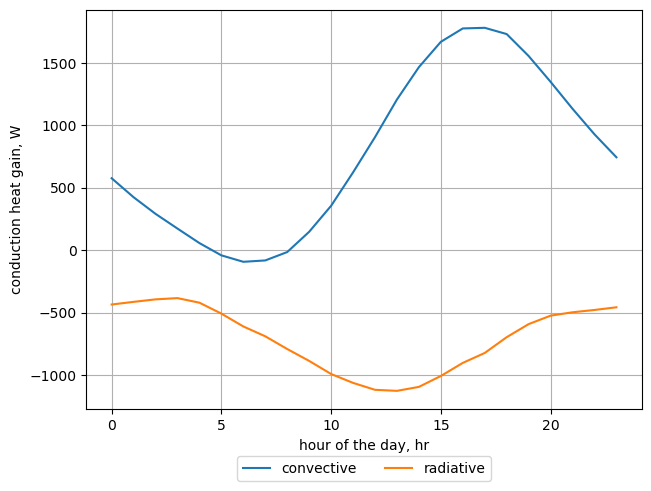

In [14]:
cond_heat_gain_chart = LineChart()
cond_heat_gain_chart.add_xy_data(
    label='convective',
    x1_values=heat_gain_overview.index,
    y1_values=heat_gain_overview.loc[:, ('Q_cond', 'conv')]
)
cond_heat_gain_chart.add_xy_data(
    label='radiative',
    x1_values=heat_gain_overview.index,
    y1_values=heat_gain_overview.loc[:, ('Q_cond', 'rad')]
)
cond_heat_gain_chart.x1.add_title('hour of the day, hr')
cond_heat_gain_chart.y1.add_title('conduction heat gain, W')
cond_heat_gain_chart.add_legend()
cond_heat_gain_chart.show()

### Solar Heat Gain

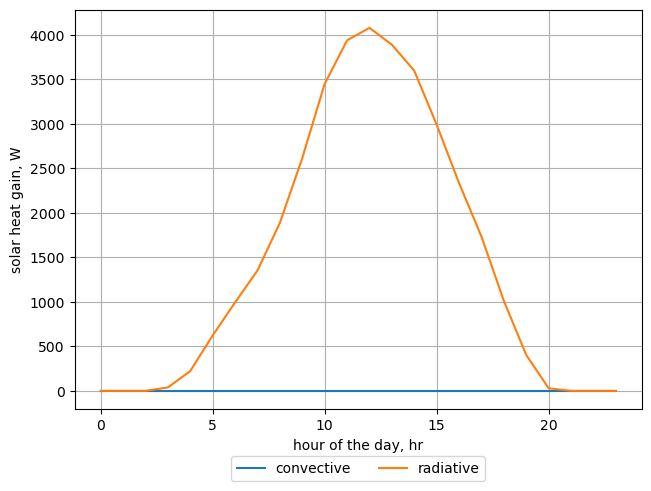

In [15]:
sol_heat_gain_chart = LineChart()
sol_heat_gain_chart.add_xy_data(
    label='convective',
    x1_values=heat_gain_overview.index,
    y1_values=heat_gain_overview.loc[:, ('Q_sol', 'conv')]
)
sol_heat_gain_chart.add_xy_data(
    label='radiative',
    x1_values=heat_gain_overview.index,
    y1_values=heat_gain_overview.loc[:, ('Q_sol', 'rad')]
)
sol_heat_gain_chart.x1.add_title('hour of the day, hr')
sol_heat_gain_chart.y1.add_title('solar heat gain, W')
sol_heat_gain_chart.add_legend()
sol_heat_gain_chart.show()

### Internal Heat Gain 

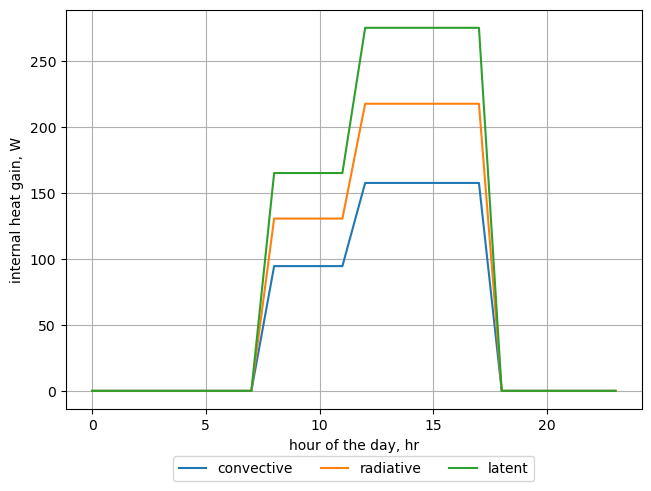

In [16]:
int_heat_gain_chart = LineChart()
int_heat_gain_chart.add_xy_data(
    label='convective',
    x1_values=heat_gain_overview.index,
    y1_values=heat_gain_overview.loc[:, ('Q_ihg', 'conv')]
)
int_heat_gain_chart.add_xy_data(
    label='radiative',
    x1_values=heat_gain_overview.index,
    y1_values=heat_gain_overview.loc[:, ('Q_ihg', 'rad')]
)
int_heat_gain_chart.add_xy_data(
    label='latent',
    x1_values=heat_gain_overview.index,
    y1_values=heat_gain_overview.loc[:, ('Q_ihg', 'lat')]
)
int_heat_gain_chart.x1.add_title('hour of the day, hr')
int_heat_gain_chart.y1.add_title('internal heat gain, W')
int_heat_gain_chart.add_legend(columns=3)
int_heat_gain_chart.show()

### Ventilation Heat Gain

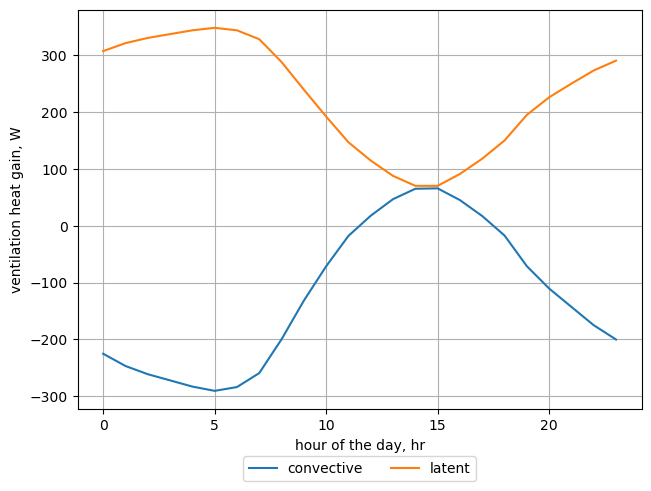

In [17]:
vent_heat_gain_chart = LineChart()
vent_heat_gain_chart.add_xy_data(
    label='convective',
    x1_values=heat_gain_overview.index,
    y1_values=heat_gain_overview.loc[:, ('Q_vent', 'conv')]
)
vent_heat_gain_chart.add_xy_data(
    label='latent',
    x1_values=heat_gain_overview.index,
    y1_values=heat_gain_overview.loc[:, ('Q_vent', 'lat')]
)
vent_heat_gain_chart.x1.add_title('hour of the day, hr')
vent_heat_gain_chart.y1.add_title('ventilation heat gain, W')
vent_heat_gain_chart.add_legend()
vent_heat_gain_chart.show()

### Heat Gain from Interior Mass

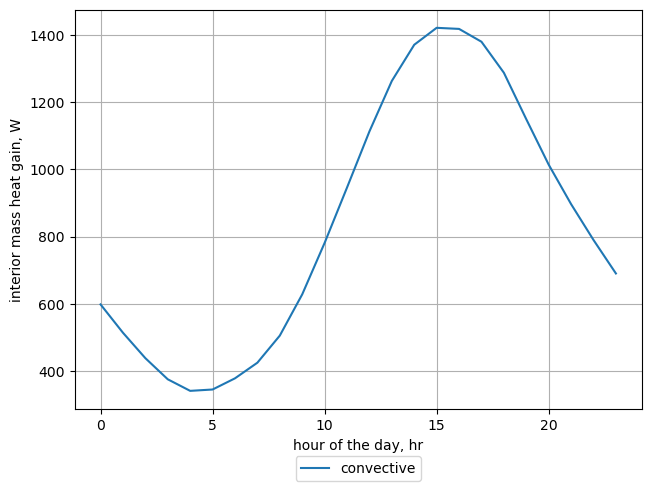

In [18]:
int_mass_gain_chart = LineChart()
int_mass_gain_chart.add_xy_data(
    label='convective',
    x1_values=heat_gain_overview.index,
    y1_values=heat_gain_overview.loc[:, ('Q_im', 'conv')]
)
int_mass_gain_chart.x1.add_title('hour of the day, hr')
int_mass_gain_chart.y1.add_title('interior mass heat gain, W')
int_mass_gain_chart.add_legend()
int_mass_gain_chart.show()

## Some Supplementary Background

### Thermal Network Model

Through the returned dataobject `sim_result` we also have access to the underlying thermal network model of the zone (attribute `zone_model` of `sim_result`). This thermal network model is implemented by the class `ThermalZoneModel`, which is derived from the base class `LinearThermalNetwork` (see package `cooling_load_calc.thermal_models`).  

In this model the construction layers in the opaque exterior building elements (exterior walls, roofs) surrounding the zone are represented by temperature nodes, each connected to a thermal capacitor, and interconnected by thermal resistors to capture the dynamic nature of the conduction heat transfer through thick exterior building elements. On the outdoor side, this linear thermal network is connected to the sol-air temperature, which depends on certain radiative characteristics of the building element's exterior surface. 

The zone itself is represented by a thermal network composed of only two temperature nodes: the zone-air node and the interior mass node. The zone-air node represents the air in the zone. The interior mass node is used to account for the thermal storage effect of the zone's interior mass (see also notebook no. 5). The zone-air node and the interior mass node of the zone are both connected to the linear thermal networks of the surrounding exterior building elements by thermal resistors through which convective, respectively radiative heat transfer takes place. 

Based on the Radiant-Time-Series (RTS) method of ASHRAE, the zone-air node takes all the convective fractions of heat gains in the zone, while the interior mass node takes all the radiative fractions. The fraction of radiative heat transfer is based on a parameter `F_rad` the user must specify when instantiating exterior building elements, windows, internal heat gains, etc. Appropriate values for this "split-parameter" can be found e.g. in ASHRAE Handbook 2017, Chapter 18, Table 14. The interior mass node and the zone air node are coupled by a thermal resistor (the interior mass surface resistance) to take account of the transfer of stored heat from the interior mass to the zone air or vice versa (see also notebook no. 5). It is up to the user to decide (estimate) what thermal capacity needs to be assigned to the interior mass node and also what value needs to be assigned to the coupling resistor when instantiating the `ThermalZone` class.

Interior building elements (interior walls, ceilings, interior doors) are represented by only two thermal resistors. One resistor connects the temperature on the other side of the interior building element with the interior mass node of the zone to represent the radiative fraction of conduction heat transfer to the zone, while the other resistor is connected with the zone air node to represent the convective fraction of conduction heat transfer to the zone. As with exterior building elements, the radiative fraction needs to be specified by the user through a parameter `F_rad`. The base value of both resistors is determined by the steady-state transmittance ($UA$) of the interior building element.

The same as for interior building elements is also applied to exterior doors and windows. In the case of exterior doors, the temperature considered on the outdoor side is the sol-air temperature, while for windows the outdoor air dry-bulb temperature is considered. 

Besides conduction heat transfer, windows are also responsible for solar heat gains entering the zone. Solar heat gains are, like internal heat gains, temperature-independent, so they can't (and don't need to) be represented by thermal resistors. Solar heat gains through windows are considered as purely radiative.

Sensible ventilation heat gains are temperature-dependent and can also be represented by thermal resistors, like:
$$
R = {1 \mathord{\left/{\vphantom {1 {\left( {\rho c\dot V} \right)}}} \right.} {\left( {\rho c\dot V} \right)}}
$$
However, sensible ventilation heat gains are only connected to the zone-air node. As such, ventilation heat gains are considered to be purely convective. A distinction is made between ventilation heat gains due to outdoor air infiltration, due to (mechanical) supply of ventilation air to the zone, and due to air transferred to the zone from adjacent zones. Each of these types is driven by another temperature difference. Air infiltration is driven by the outdoor air dry-bulb temperature, ventilation air supply by the supply air temperature, and air transfer by the air temperature in the adjacent zone.

A linear thermal network is composed of temperature nodes, which are represented by the class `TemperatureNode`. We can have a look at all the temperature nodes in the thermal zone model: 

In [19]:
print(sim_result.zone_model.nodes)

(outer_leaf[1]@ew_W, outer_leaf[2]@ew_W, outer_leaf[3]@ew_W, outer_leaf[4]@ew_W, outer_leaf[5]@ew_W, outer_leaf[6]@ew_W, outer_leaf[7]@ew_W, outer_leaf[8]@ew_W, outer_leaf[9]@ew_W, outer_leaf[10]@ew_W, insulation[1]@ew_W, insulation[2]@ew_W, insulation[3]@ew_W, insulation[4]@ew_W, insulation[5]@ew_W, inner_leaf[1]@ew_W, inner_leaf[2]@ew_W, inner_leaf[3]@ew_W, inner_leaf[4]@ew_W, inner_leaf[5]@ew_W, inner_leaf[6]@ew_W, inner_leaf[7]@ew_W, inner_leaf[8]@ew_W, inner_leaf[9]@ew_W, inner_leaf[10]@ew_W, inner_leaf[11]@ew_W, inner_leaf[12]@ew_W, inner_leaf[13]@ew_W, inner_leaf[14]@ew_W, inner_leaf[15]@ew_W, gypsum_layer[1]@ew_W, T_is@ew_W, outer_leaf[1]@ew_S, outer_leaf[2]@ew_S, outer_leaf[3]@ew_S, outer_leaf[4]@ew_S, outer_leaf[5]@ew_S, outer_leaf[6]@ew_S, outer_leaf[7]@ew_S, outer_leaf[8]@ew_S, outer_leaf[9]@ew_S, outer_leaf[10]@ew_S, insulation[1]@ew_S, insulation[2]@ew_S, insulation[3]@ew_S, insulation[4]@ew_S, insulation[5]@ew_S, inner_leaf[1]@ew_S, inner_leaf[2]@ew_S, inner_leaf[3]@ew_S

We see that the thermal zone network model also contains the nodes of the exterior building elements to which it is connected.

The zone-air node and the interior mass node are accessible through attributes of the `ThermalZoneModel` object. We can take a look at the thermal resistors to which the zone-air node is connected and to the temperature labels on their other terminal:

In [20]:
if sim_result.zone_model.zone_air_node.resistors_in:
    for resistor_tuple in sim_result.zone_model.zone_air_node.resistors_in:
        print(f"{resistor_tuple[0]}: {resistor_tuple[1]}")
else:
    print("no input resistors")

T_im@zone_1: 8.56×10⁻⁷ h·K/J
T_is@ew_W: 2.8×10⁻⁶ h·K/J
T_is@ew_S: 2.4×10⁻⁶ h·K/J
T_is@ew_E: 3.78×10⁻⁶ h·K/J
T_is@rf_S: 8.6×10⁻⁷ h·K/J
T_ext_db@zone_1: 4.42×10⁻⁶ h·K/J
T_sa@ed_E1: 7.79×10⁻⁵ h·K/J
T_za@zone_2: 2.67×10⁻⁵ h·K/J


We see that the zone-air node is connected to the interior mass node temperature (`T_im@zone1`), to the interior surface node temperatures of the exterior building elements surrounding the thermal zone (`T_is@ew_W`, ...), to the outdoor air dry-bulb temperature (`T_ext_db@zone1`), to the sol-air temperature on the outdoor side of the exterior door (`T_sa@ed_E1`), and to the zone-air temperature of the adjacent thermal zone (`T_za@zone_2`).

Besides heat transfer through thermal resistors, heat flows can also enter or leave a temperature node directly. Let us have a look at heat flows that enter the zone-air node directly:

In [21]:
if sim_result.zone_model.zone_air_node.heat_flows_in:
    for heat_flow in sim_result.zone_model.zone_air_node.heat_flows_in:
        print(heat_flow)
else:
    print("no heat flows are entering directly")

Q_gain_conv@zone_1
Q_hvac@zone_1


> **Note**<br>
A temperature node (`TemperatureNode` object) has two sides: an input and an output side for heat flow. For resistors and temperature-independent heat flows on the input side (`resistors_in`, `heat_flows_in`), it is assumed as reference that positive heat flow is directed towards the node, while for resistors and heat flows on the output side (`resistors_out`, `heat_flows_out`), it is assumed as reference that positive heat flow is directed away from the node.    

In [22]:
if sim_result.zone_model.zone_air_node.resistors_out:
    for resistor_tuple in sim_result.zone_model.zone_air_node.resistors_out:
        print(f"{resistor_tuple[0]}: {resistor_tuple[1]}")
else:
    print("no output resistors")

no output resistors


In [23]:
if sim_result.zone_model.zone_air_node.heat_flows_out:
    for heat_flow in sim_result.zone_model.zone_air_node.heat_flows_out:
        print(heat_flow)
else:
    print("no heat flows are leaving directly")

no heat flows are leaving directly


We see that the zone-air node has no resistors connected on its output side, nor heat flows that are leaving on the output side. 

The same could also be done for the interior mass node (`sim_result.zone_model.int_mass_node`).

### Thermal Zone Feedback System

The thermal network model of a thermal zone (class `ThermalZoneModel`) can be considered as an intermediary layer -in fact, it is more like a data structure- that receives the user data from the upper layer (class `ThermalZone`) to create and configure the temperature nodes (see method `assemble(...)` of class  `ThermalZoneModel`). Next, to determine the heat gains, and ultimately the heat rate that the HVAC-system needs to supply or extract from the thermal zone, we first have to solve for the temperatures of the nodes in the thermal network model. For this purpose, the third-party package `python-control` ([Python Control Systems Library](https://github.com/python-control/python-control)) is used.

For each node in the network model a heat or energy balance (node equation) can be written. Each node equation is a first-order differential equation. As such, we arrive at a set of first-order differential equations, which can be arranged in a so-called state-space model, being a mathematical description of a system (see method `create_feedback_system(...)`). A state-space model in the `python-control` package is represented by a `StateSpace` object (which consists of a state or system matrix A, an input matrix B, an output matrix C, and a feedforward matrix D). This `StateSpace` object can then be solved with the function `forced_response(...)` in the `python-control` package.

When method `simulate(...)` is called, the state-space representation of the thermal zone is further integrated in a closed-loop, negative feedback system. The input of the thermal zone system is the output of the zone's temperature controller (either a P- or PI-controller). The temperature controller directly controls the output power of the HVAC-system, as was already mentioned above in the paragraph "Simulation of the Thermal Zone".

![feedback system block diagram](./static/feedback-system-scheme.png)

The object of the complete feedback system is accessible through `sim_result.feedback_system` (a `control.StateSpace` object).

In [24]:
print(sim_result.feedback_system)

<StateSpace>: zone_1
Inputs (10): ['T_sp@zone_1', 'T_sa@ew_W', 'T_sa@ew_S', 'T_sa@ew_E', 'T_sa@rf_S', 'T_ext_db@zone_1', 'T_sa@ed_E1', 'T_za@zone_2', 'Q_gain_rad@zone_1', 'Q_gain_conv@zone_1']
Outputs (8): ['T_za@zone_1', 'T_im@zone_1', 'T_is@ew_W', 'T_is@ew_S', 'T_is@ew_E', 'T_is@rf_S', 'Q_hvac', 'error']
States (8): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'x[7]']

A = [[-1.69337456e-02  1.09060525e+00 -8.15585746e-02 -1.46827484e-01
      -5.97864099e-02 -9.26491441e-03  1.34990537e-02 -2.42411569e-03]
     [-1.03449675e+00 -5.14194157e+00  2.25528245e+00  3.44453718e+00
       1.36381735e+00  2.07234974e-01 -3.01491100e-01  5.41294379e-02]
     [-7.12375091e-02 -2.22934798e+00 -1.36548130e+00 -3.89510900e+00
      -1.73912911e+00 -2.88366564e-01  4.21916794e-01 -7.56893280e-02]
     [-1.46028030e-01 -2.70836760e+00 -3.02614296e+00 -1.54140845e+01
      -8.63765570e+00 -1.80348764e+00  2.71001736e+00 -4.98631671e-01]
     [-5.62171492e-02 -7.89241851e-01 -1.08063107e

We can see that the actual system has more outputs than are indicated in the block diagram (only the zone-air temperature). The additional outputs are intermediate results of the simulation (the interior mass node temperature, the interior surface node temperatures of the exterior building elements, the heat rate from the HVAC-system, and the error signal at the input of the controller). The node temperatures are needed for calculating the heat gains that depend on these temperatures. 